In [1]:
import pandas as pd 
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
%matplotlib
from scipy import stats
import sys
from sklearn import metrics
import os
import seaborn as sns
from sklearn import cluster

Using matplotlib backend: MacOSX


In [2]:
input_dir = sys.argv[0]
output_dir = sys.argv[1]

In [3]:
input_dir = "/Users/tomi/Downloads/config/validation_prediction/export_permutation_runs"
output_dir =     

In [44]:
from sklearn.metrics import mean_squared_error
def analyse_results(input_dir, output_path):

    results = [y for x in os.walk(input_dir) for y in glob.glob(os.path.join(x[0], '*predictions*'))]
    data = load_results(results)
    os.makedirs(output_path, exist_ok=True)
    data.to_csv("{}/data_combined.csv".format(output_path), header=True)
    
    
    data['prediction_rf_lsqe'] = np.power((np.log(1+data['actual']) - np.log(1+data['prediction_rf'])),2)
    data_mean = data.groupby(["type_1"]).mean().sort_values("prediction_rf_ape")
    data_indx = data.set_index(["type_1"])

    
    return data_indx, data_mean

def load_results(results):
    data = []
    for f in results:
        d = pd.read_csv(f, sep=" ")
        file = os.path.basename(f)
        f = f.replace(input_dir, "")
        f = f.replace(file, "")
        dir_splits = f.split("/")
        type_1 = dir_splits[1]
        type_2 = dir_splits[2]
        d["type_1"] = type_1
        #d["type_2"] = type_2
        data.append(d)
    data = pd.concat(data)
    data = data.round(2)
    return data

def select_extremes(data, data_mean, number):
    
    best = data_mean.index.values[:number]
    worst = data_mean.index.values[-number:]
    show = np.concatenate([best, worst])

    return data.loc[show].reset_index()

def violin_plot(data_show, output_dir, col, name, ylabel='Absolute Percentage Error [%]'):
    figure= plt.figure(figsize=[10, 7])
    sns.set_style("whitegrid")
  
    ax = sns.violinplot(data=data_show, x="type_1", y=col,  
                     fliersize=0, palette=sns.color_palette("Set1", n_colors=8, desat=.5))

    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='white', linestyle='dashed')
    plt.xlabel('Feature classes')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.title("Accuracy of predicting BMI")
    plt.savefig("{}/{}.pdf".format(output_dir, name))
    plt.xticks(rotation=90)

    
def line_plot(data_show, output_dir, col, name, ylabel='Absolute Percentage Error [%]'):
    figure= plt.figure(figsize=[10, 7])
    sns.set_style("whitegrid")
    dat_show_mean = data_show.groupby(["type_1"]).median().reset_index()
    plt.plot(dat_show_mean["type_1"], dat_show_mean[col])

    plt.xlabel('Feature classes')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.title("Accuracy of predicting BMI")
    plt.xticks(rotation=90)
    plt.savefig("{}/{}.pdf".format(output_dir, name))
    
def boxplot(data_show, output_dir, col, name, ylabel='Absolute Percentage Error [%]'):
    figure= plt.figure(figsize=[10, 7])
    sns.set_style("whitegrid")
    ax = sns.boxplot(data=data_show, x="type_1", y=col, palette=sns.color_palette("Set1", n_colors=8, desat=.5))

    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='white', linestyle='dashed')
    plt.xlabel('Feature classes')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.title("Accuracy of predicting BMI")
    plt.xticks(rotation=90)

    plt.savefig("{}/{}.pdf".format(output_dir, name))

    

In [ ]:
data_all, data_mean = analyse_results(input_dir, output_dir)
data_show = select_extremes(data_all, data_mean, 3)

data_show = data_show.replace([np.inf, -np.inf], np.nan)
initial_number = data_show.shape[0]
bad_values = data_show[data_show.isnull().any(axis=1)]
bad_values.to_csv("{}/bad_values.csv".format(output_dir), header=True)
data_show = data_show.dropna(subset=['prediction_rf', 'prediction_rf_lsqe'])
dropna_number = initial_number - data_show.shape[0]
print("Dropped {} invalid values".format(dropna_number))



violin_plot(data_show, output_dir, 'prediction_rf_ape', name="violin_plot_APE.pdf")
boxplot(data_show, output_dir, 'prediction_rf_ape', name="boxplot_APE.pdf")
line_plot(data_show, output_dir, 'prediction_rf_ape', name="lineplot_APE.pdf")

violin_plot(data_show, output_dir, 'prediction_rf_lsqe', ylabel="Squared logarithmic error", name="violin_plot_SLE.pdf")
boxplot(data_show, output_dir, 'prediction_rf_lsqe', ylabel="Squared logarithmic error", name="boxplot_SLE.pdf")
line_plot(data_show, output_dir, 'prediction_rf_lsqe', ylabel="Squared logarithmic error", name="lineplot_SLE.pdf")



In [7]:
results = [y for x in os.walk(input_dir) for y in glob.glob(os.path.join(x[0], '*variable_importance_*'))]


In [8]:
data_full = []
for r in results:
    data = pd.read_csv(r, sep=" ")
    run = r.split("/")[-2]
    data["run"] = run
    data = data.sort_values(["IncNodePurity"])
    data["rank"] = range(0, data.shape[0])
    data_full.append(data)
data_full = pd.concat(data_full)

In [9]:
data_full_mean = data_full.groupby(["run","Variables"]).mean().sort_values("rank")

In [10]:
results = [y for x in os.walk(input_dir) for y in glob.glob(os.path.join(x[0], '*permut_results_*'))]
data_permutations = []
for r in results:
    data = pd.read_csv(r, sep=" ")
    run = r.split("/")[-2]
    number = r.split("/")[-1]
    number = number.split("_")[-1]
    data["run_id"] = int(number)
    data["type_1"] = run

    data_permutations.append(data)
data_permutations = pd.concat(data_permutations)


In [45]:
data_all_merged = pd.merge(data_all.groupby(["type_1", "run_id"]).mean().reset_index(), data_permutations, on = ["type_1", "run_id"])

In [46]:
test = data_all_merged.groupby(["type_1", "run_id"]).apply(lambda x: (x[x["prediction_rf_ape"] >= x["x"]].shape[0]/10)).reset_index()
test.columns = ["type_1", "run_id", "p-value"]

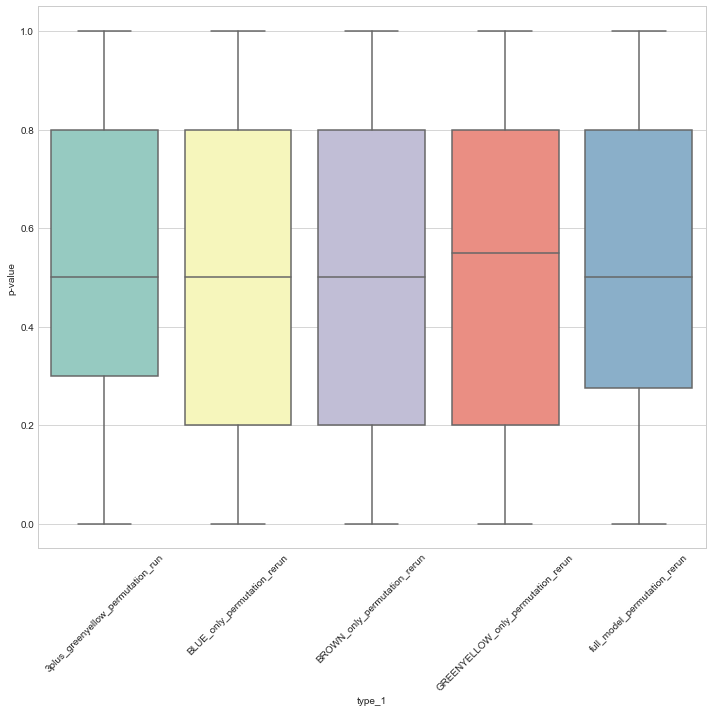

In [47]:
fig = plt.figure(figsize=[10,10])
ax = sns.boxplot(x="type_1", y="p-value",  data=test, palette="Set3")
plt.xticks(rotation=45)
fig.tight_layout()


In [ ]:
test.groupby(["type_1", "run_id"]).hist()

In [334]:
## import seaborn as sns
#sns.pairplot(example[["type_2","prediction_rf_ape", "actual"]], hue="type_2", size=1)

In [ ]:
#data["error"] =  np.abs(data["prediction_glmnet"] - data["actual"] )/data["actual"] *100

#data["label"] = np.digitize(data["actual"],bins=[24.9], right=True)
#data = data[data["label"] != 0]
#data["label_predicted"] = np.digitize(data["prediction_rf"],bins=[24.9], right=True)


#data["label_3"] = np.digitize(data["actual"],bins=[24.9,  29.9], right=True)
#data = data[data["label"] != 0]
#data["label_predicted_3"] = np.digitize(data["prediction_rf"],bins=[24.9,  29.9], right=True)

#data["label_4"] = np.digitize(data["actual"],bins=[18.5, 24.9,  29.9], right=True)
#data = data[data["label"] != 0]
#data["label_predicted_4"] = np.digitize(data["prediction_rf"],bins=[18.5, 24.9,  29.9], right=True)


#underweheight = [0,18.5]

#healthy = [18.5,24.9 ]
#overweight = [24.9, 29.9]
#obese = [30]

